In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [2]:
env = gym.make("Blackjack-v1")

In [77]:
def policy(observation, Q, epsilon=0.1):
    # 实现了一个带有 epsilon-贪婪策略的动作选择机制
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[observation])

In [78]:
def generate_episode(env, policy, Q):
    # 给定环境中根据策略生成一个完整的游戏回合，它通过在环境中不断执行动作，记录状态、动作和奖励，直到回合结束
    episode = []
    state, _ = env.reset()
    while True:
        action = policy(state, Q)
        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

In [79]:
def plot_value_function(Q, title):
    # 通过遍历 Q 值表并绘制每个状态下的最大 Q 值，生成价值函数图表。它使用 imshow 函数在两个子图中分别展示有可用 A 和没有可用 A 的状态下的价值函数
    value_function = np.zeros((32, 11, 2))
    for (player_sum, dealer_showing, usable_ace), actions in Q.items():
        value_function[player_sum, dealer_showing, int(usable_ace)] = np.max(actions)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, usable_ace in enumerate([1, 0]):
        ax[i].imshow(value_function[:, :, usable_ace], cmap='cool', origin='lower')
        ax[i].set_title(f"{title} (Usable Ace = {usable_ace})")
        ax[i].set_xlabel("Dealer Showing")
        ax[i].set_ylabel("Player Sum")
        ax[i].set_xticks(np.arange(11))
        ax[i].set_yticks(np.arange(32))
        ax[i].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'A']) 
        ax[i].set_yticklabels([str(i) for i in range(32)])
    plt.show()

In [80]:
# Monte Carlo
def monte_carlo_control(env, num_episodes, gamma=1.0, epsilon=0.1):
    '''
    用蒙特卡罗方法，通过生成多个回合并计算每个状态-动作对的平均回报，来估计 Q 值
    这种方法在回合结束时更新 Q 值，并确保每个状态-动作对的估计值是基于该对所有出现过的回合的平均回报
    该方法适用于确定策略的长期回报，并在不同的探索和利用之间找到平衡
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    for i in range(num_episodes):
        episode = generate_episode(env, policy, Q)
        G = 0
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if not any(x[0] == state and x[1] == action for x in episode[:t]):
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
    return Q

# 四种 Monte Carlo、Sarsa、Q-Learning 和 Deep Q-Learning 强化算法的的优劣
## 1. Monte Carlo 控制
Monte Carlo 方法通过采样多个完整的回合，计算每个状态-动作对的平均回报来估计 Q 值。它依赖于多次采样来获得准确的 Q 值估计。
### 优点：
简单直观：基于完整回合计算平均回报，算法易于理解和实现。
无需模型：不需要知道环境的动态模型，适用于任意环境。
### 缺点：
需要大量样本：为了获得准确的估计，需要大量的回合。
只能在终止状态时更新：只有在一个回合结束时才能更新 Q 值，更新频率较低。
## 2. Sarsa（State-Action-Reward-State-Action）
Sarsa 是一种基于在线策略的时序差分（Temporal Difference, TD）方法，它使用当前策略估计 Q 值。
### 优点：
在线更新：每一步都更新 Q 值，提高了更新频率。
收敛到确定策略：能够收敛到一个确定策略，而不只是一个最优值。
### 缺点：
保守：可能收敛到一个次优策略，因为它总是遵循当前策略选择动作。
## 3. Q-Learning
Q-Learning 是一种基于离线策略的时序差分方法，它使用最优策略估计 Q 值。
### 优点：
能够找到最优策略：使用 Bellman 方程更新 Q 值，最终能够找到最优策略。
更新频率高：每一步都更新 Q 值。
### 缺点：
可能不稳定：由于使用的是最优策略，可能导致不稳定和震荡。
探索与利用平衡：需要精心调整探索与利用之间的平衡。
## 4. Deep Q-Learning (DQN)
Deep Q-Learning 使用深度神经网络来估计 Q 值，并引入经验回放和目标网络来提高稳定性。
### 优点：
处理高维状态：能够处理复杂和高维的状态空间。
稳定性：引入经验回放和目标网络，缓解了非稳定性问题。
### 缺点：
计算资源需求高：需要大量的计算资源和时间进行训练。
超参数敏感：需要仔细调整超参数，才能取得好的性能。

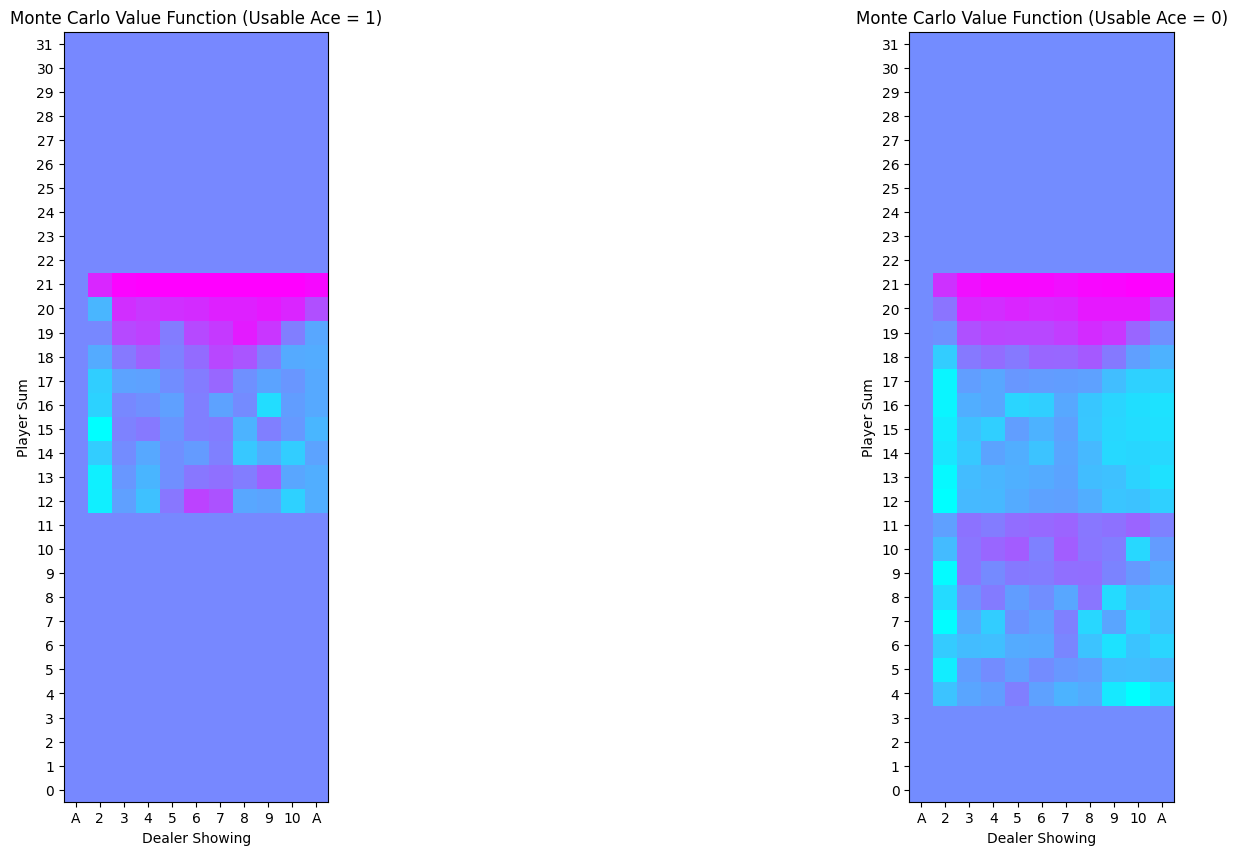

In [81]:
num_episodes = 50000
Q_mc = monte_carlo_control(env, num_episodes)
plot_value_function(Q_mc, "Monte Carlo Value Function")

In [82]:
# Sarsa
def sarsa(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.1):
    '''
    SARSA 算法是一种在线强化学习算法，通过生成多个回合并在每一步更新 Q 值来估计每个状态-动作对的价值
    该方法在每一步都考虑了当前动作及其后续动作的影响，通过不断调整 Q 值来逼近最优策略
    SARSA 算法能够在探索和利用之间找到平衡，有助于学习出有效的策略。
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(num_episodes):
        state, _ = env.reset()
        action = policy(state, Q, epsilon)
        while True:
            next_state, reward, done, _, _ = env.step(action)
            next_action = policy(next_state, Q, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            if done:
                break
            state = next_state
            action = next_action
    return Q

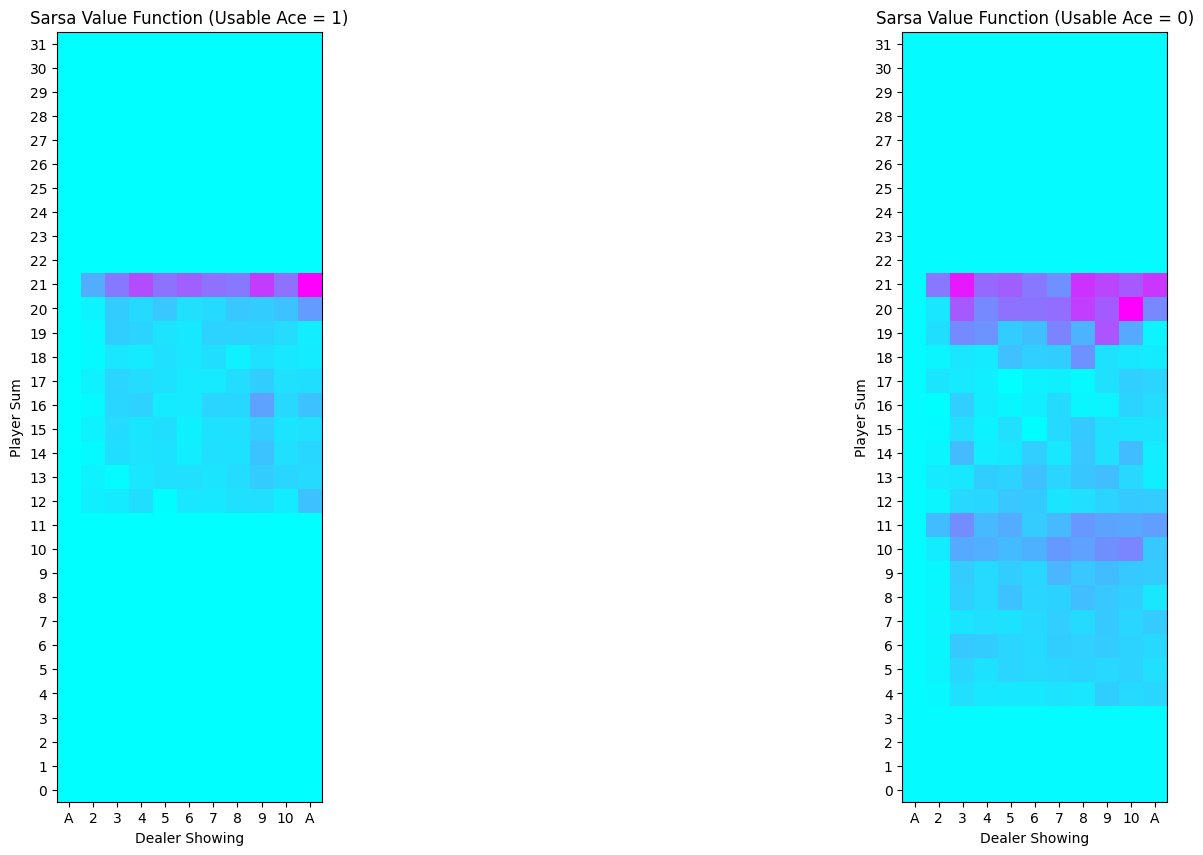

In [83]:
num_episodes = 50000
Q_sarsa = sarsa(env, num_episodes)
plot_value_function(Q_sarsa, "Sarsa Value Function")

In [84]:
# Q-Learning
def q_learning(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.1):
    '''
    Q-Learning 算法是一种离线强化学习算法，通过生成多个回合并在每一步更新 Q 值来估计每个状态-动作对的价值
    与 SARSA 算法不同,Q-Learning 使用下一个状态的最大 Q 值来更新当前状态的 Q 值，因此被称为离线算法
    该方法通过不断调整 Q 值来逼近最优策略，并能够在探索和利用之间找到平衡，有助于学习出有效的策略
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(num_episodes):
        state, _ = env.reset()
        while True:
            action = policy(state, Q, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            if done:
                break
            state = next_state
    return Q

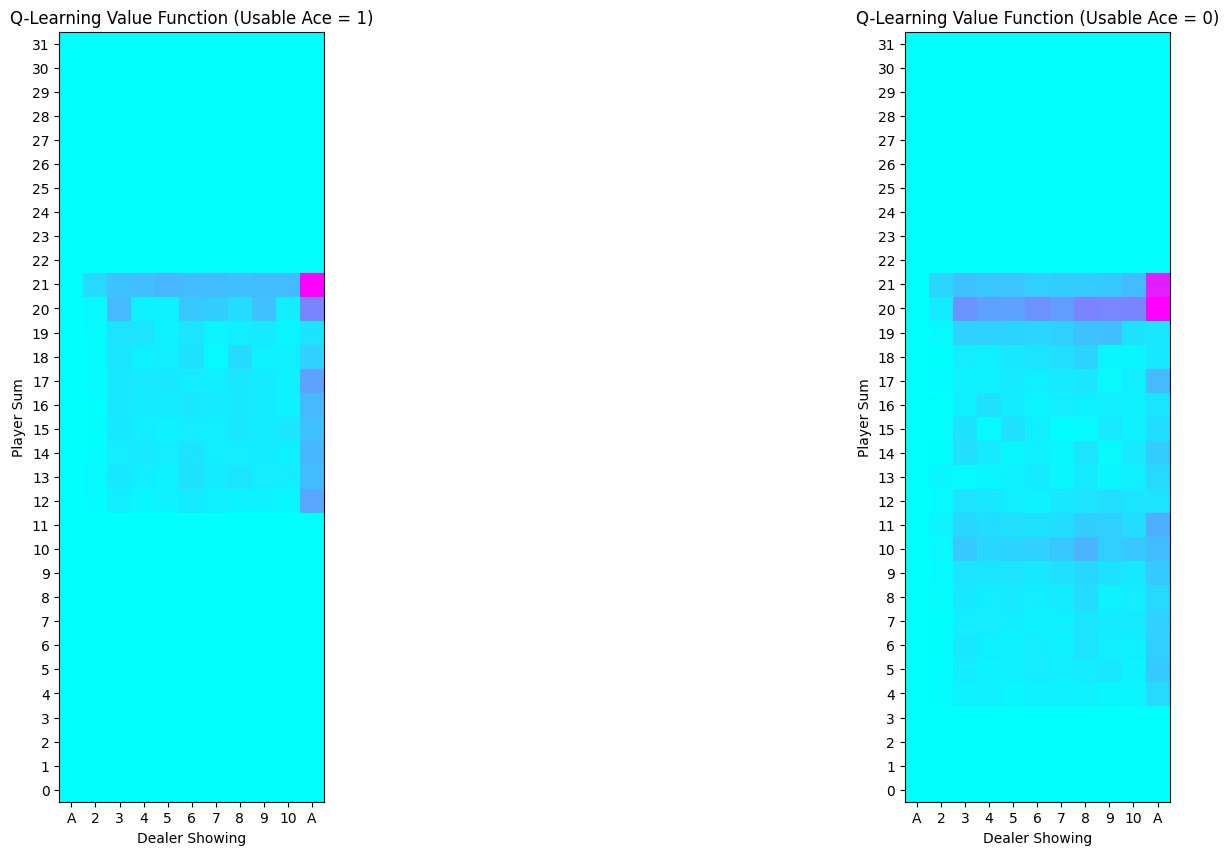

In [85]:
num_episodes = 50000
Q_ql = q_learning(env, num_episodes)
plot_value_function(Q_ql, "Q-Learning Value Function")

In [86]:
# DQN
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [87]:
def dqn(env, num_episodes, gamma=1.0, epsilon=0.1, epsilon_min=0.01, epsilon_decay=0.995, alpha=0.001, batch_size=64):
    '''
    DQN 算法通过神经网络估计 Q 值，利用经验回放缓冲区和目标网络来稳定训练过程。该方法能够处理高维度的状态和动作空间，有助于在复杂环境中学习有效的策略
    '''
    state_size = 3
    action_size = env.action_space.n
    q_network = DQN(state_size, action_size)
    target_network = DQN(state_size, action_size)
    optimizer = optim.Adam(q_network.parameters(), lr=alpha)
    criterion = nn.MSELoss()
    replay_buffer = deque(maxlen=2000)
    
    def get_action(state, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state)
        return np.argmax(q_values.numpy())
    
    def train_step():
        if len(replay_buffer) < batch_size:
            return
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = target_network(next_states).max(1)[0]
        targets = rewards + gamma * next_q_values * (1 - dones)
        
        loss = criterion(q_values, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        while True:
            action = get_action(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            replay_buffer.append((state, action, reward, next_state, done))
            train_step()
            state = next_state
            total_reward += reward
            if done:
                break
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        if episode % 100 == 0:
            target_network.load_state_dict(q_network.state_dict())
    
    return q_network

In [88]:
def plot_dqn_value_function(model, title):
    value_function = np.zeros((32, 11, 2))
    for player_sum in range(32):
        for dealer_showing in range(11):
            for usable_ace in [0, 1]:
                state = (player_sum, dealer_showing, usable_ace)
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    action_values = model(state_tensor)
                value_function[player_sum, dealer_showing, usable_ace] = action_values.max().item()
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, usable_ace in enumerate([1, 0]):
        ax[i].imshow(value_function[:, :, usable_ace], cmap='cool', origin='lower')
        ax[i].set_title(f"{title} (Usable Ace = {usable_ace})")
        ax[i].set_xlabel("Dealer Showing")
        ax[i].set_ylabel("Player Sum")
        ax[i].set_xticks(np.arange(11))
        ax[i].set_yticks(np.arange(32))
        ax[i].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'A']) 
        ax[i].set_yticklabels([str(i) for i in range(32)])
    plt.show()

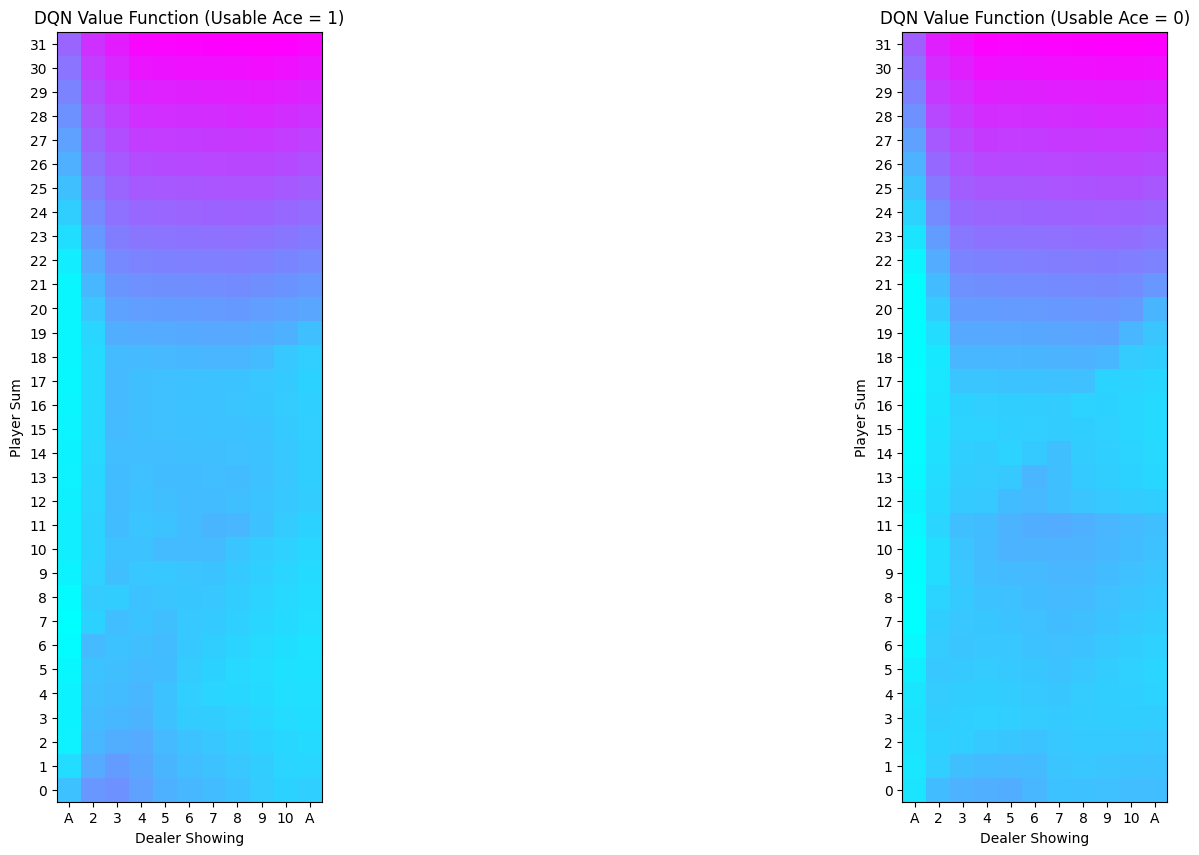

In [89]:
# Training the models
num_episodes = 50000
dqn_model = dqn(env, num_episodes)
plot_dqn_value_function(dqn_model, "DQN Value Function")